In [ ]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer

from nltk.util import ngrams

from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import confusion_matrix, log_loss
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report


# Importing Deep Learning Libraries

from keras.layers import Embedding
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional, SpatialDropout1D
# Generally, we use softmax activation instead of sigmoid with the cross-entropy loss 
# because softmax activation distributes the probability throughout each output node.
# But, since it is a binary classification, using sigmoid is same as softmax. 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import nltk
import string
import re
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Reading the Data

In [ ]:
train_df = pd.read_csv("/content/drive/My Drive/train.csv")
test_df = pd.read_csv("/content/drive/My Drive/test.csv")

In [ ]:
# Exploratory Data Analysis

In [ ]:
print(train_df.shape)

(1306122, 3)


In [ ]:
print(test_df.shape)

(375806, 2)


In [ ]:
# Checking the initial values of the training dataset
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [ ]:
# Checking the information for the train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306122 entries, 0 to 1306121
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   qid            1306122 non-null  object
 1   question_text  1306122 non-null  object
 2   target         1306122 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 29.9+ MB


In [ ]:
# Checking for any null values in the dataset
train_df.isnull().sum()

qid              0
question_text    0
target           0
dtype: int64

In [ ]:
test_df.isnull().sum()

qid              0
question_text    0
dtype: int64

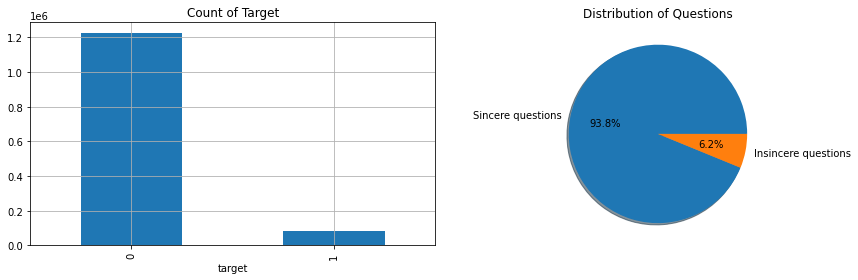

In [ ]:
# Plotting the data distribution
plt.subplot(1,2,1) # provides a way to plot multiple graphs on the same line
train_df.groupby('target')['qid'].count().plot.bar()
plt.grid(True)
plt.title("Count of Target")
plt.subplots_adjust(right=2)

#plotting a pie-chart
plt.subplot(1,2,2)
values = [train_df[train_df['target']==0].shape[0], train_df[train_df['target']==1].shape[0]]
labels = ['Sincere questions', 'Insincere questions']

plt.pie(values, labels=labels, autopct='%1.1f%%', shadow=True)
plt.title('Distribution of Questions')
plt.tight_layout()
plt.subplots_adjust(right=2)



plt.show()

In [ ]:
# From the above plots we can say that the data is highly imbalance with only 6.2% questions as insincere.


In [ ]:
# Plotting a WordCloud
# Creating a function to plot the wordcloud

def wordcloud_display(data, title):
  wordlist = data.unique().tolist() # converts the text from numpy array into a list
  words = ''.join(wordlist) # converting the list to a string for the wordcloud generation

  quora_wc = WordCloud(width = 3000, height = 2000,
                       random_state=1, background_color='white', 
                       colormap='Set1', collocations=False,
                       stopwords = set(STOPWORDS)).generate(words)
  plt.figure(figsize=(20, 12))
  plt.imshow(quora_wc)
  plt.title(f'List of Frequent Words in {title}')
  plt.axis("off")
  plt.show()

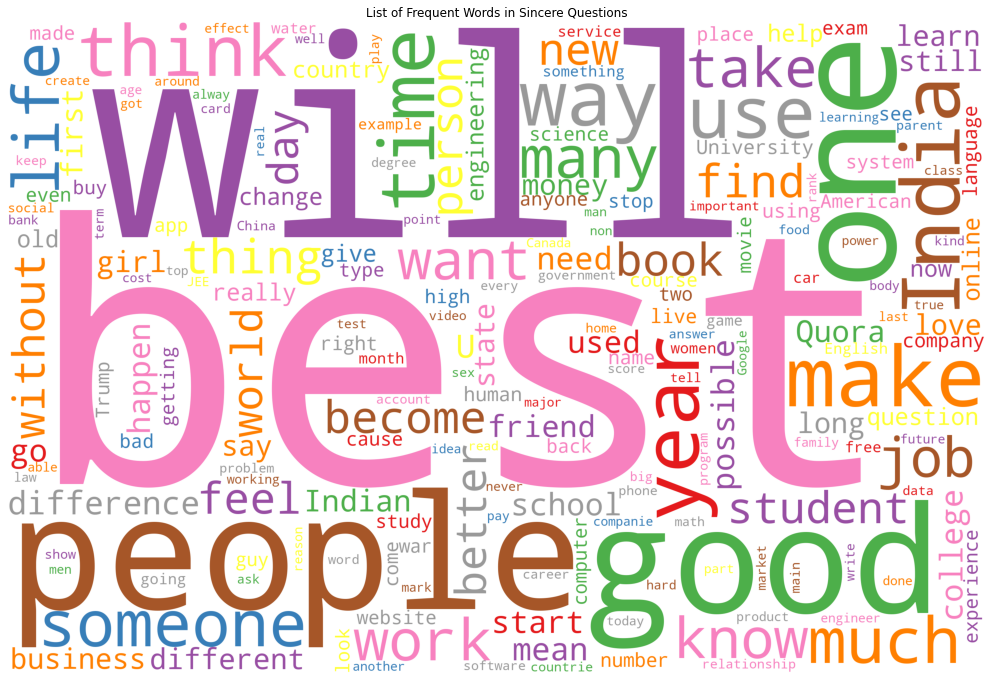

In [ ]:
# Wordcloud for Sincere Questions
wordcloud_display(train_df[train_df['target']==0]['question_text'], 'Sincere Questions')


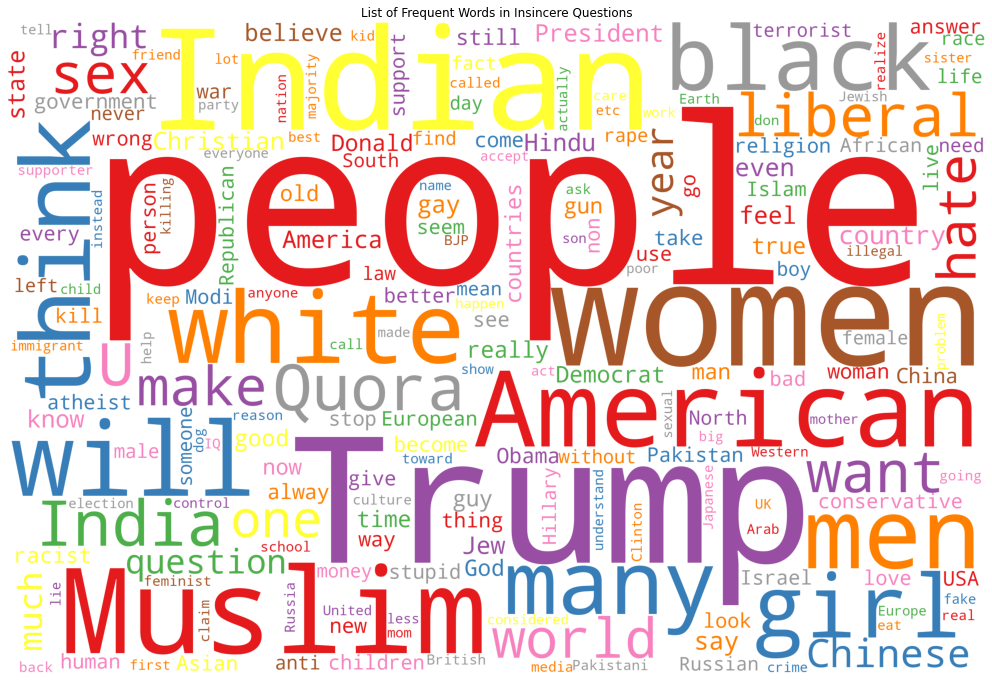

In [ ]:
# Wordcloud for Inincere Questions
wordcloud_display(train_df[train_df['target']==1]['question_text'], 'Insincere Questions')


In [ ]:
# # Generating a list of Top words from Sincere and Insincere Questions which would be then passed to the n-grams function
from collections import Counter

def top_word_freq(data, title,colors):
  topwords = Counter(data).most_common(20)  #Gets us a Top 20 Words from the questions
  df_top = pd.DataFrame(topwords,columns=['word','count']).sort_values('count') #storing the frequent words in a dataframe
  plt.barh(df_top['word'].values, df_top['count'].values, orientation='horizontal', color=colors) # plot
  plt.title(f'Top words in {title}')

In [ ]:
# Creating N-grams
# N-grams are nothing but a neighbouring sequences of items in the word document

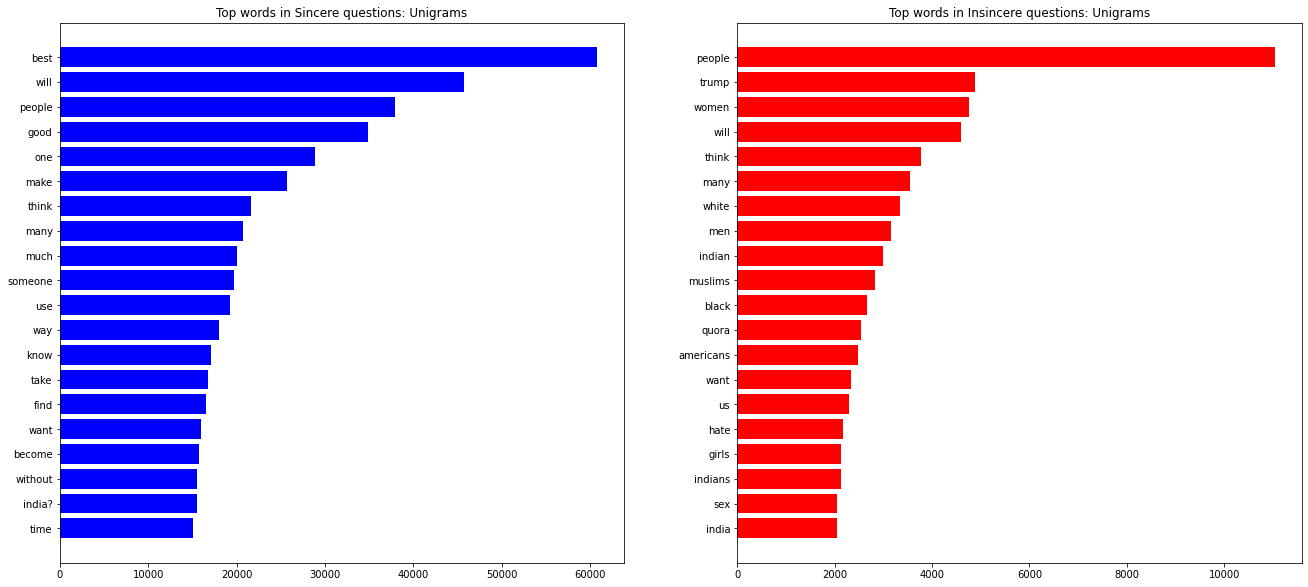

In [ ]:
def unigrams(data):
  unigrams_list = []
  for item in data:
    unigrams_list.extend([w for w in item.lower().split() if w not in STOPWORDS])
  return unigrams_list

unigrams_sincere = unigrams(train_df[train_df['target']==0]['question_text'])
unigrams_insincere = unigrams(train_df[train_df['target']==1]['question_text'])


plt.subplot(1, 2, 1)
top_word_freq(unigrams_sincere, 'Sincere questions: Unigrams','blue')

# Unigrams Insincere words
plt.subplot(1, 2, 2)
top_word_freq(unigrams_insincere, 'Insincere questions: Unigrams','red')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

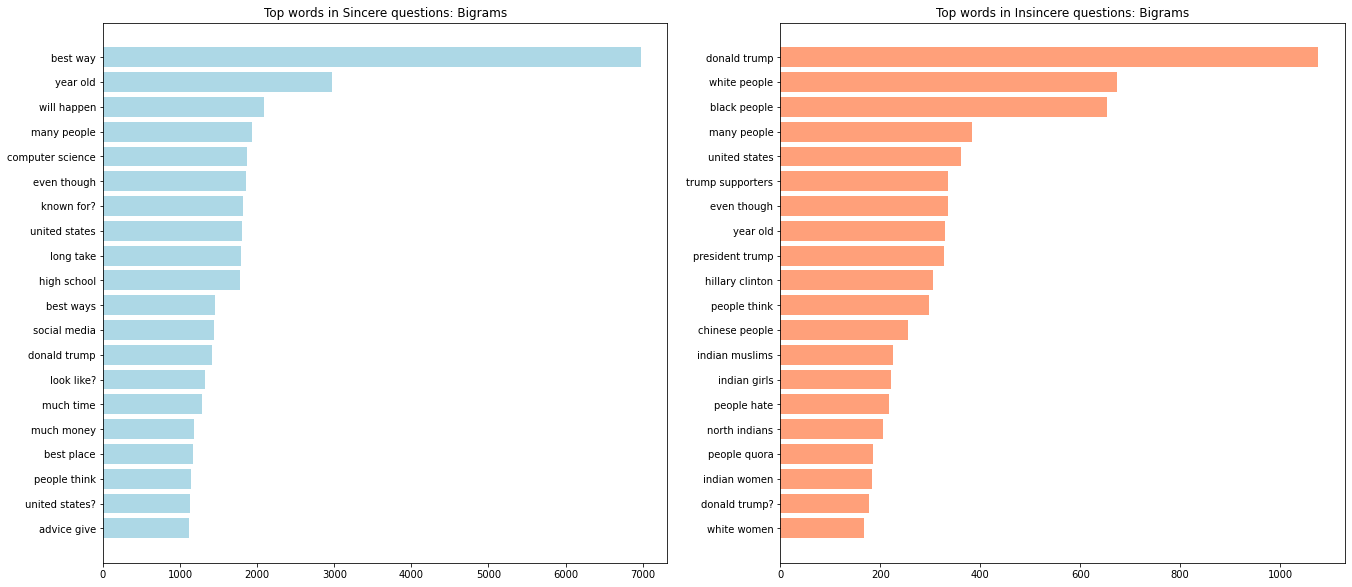

In [ ]:
def bigrams(data):
  bigrams_list = []
  for item in data:
    item= [word1 for word1 in item.lower().split() if word1 not in STOPWORDS]
    bi = [word2 for word2 in nltk.bigrams(item)]
    bi = [' '.join(word1) for word1 in bi]
    bigrams_list.extend(bi)
  return bigrams_list

bigrams_sincere = bigrams(train_df[train_df['target']==0]['question_text'])
bigrams_insincere = bigrams(train_df[train_df['target']==1]['question_text'])


# Bigrams Sincere words
plt.subplot(1, 2, 1)
top_word_freq(bigrams_sincere, 'Sincere questions: Bigrams', 'lightblue')

# Bigrams Insincere words
plt.subplot(1, 2, 2)
top_word_freq(bigrams_insincere, 'Insincere questions: Bigrams', 'lightsalmon')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

In [ ]:
def trigrams(data):
  trigrams_list = []
  for item in data:
    item = [word3 for word3 in item.lower().split() if word3 not in STOPWORDS]
    tri = [t for t in nltk.trigrams(item)]
    tri = [' '.join(word3) for word3 in tri]
    trigrams_list.extend(tri)
  return trigrams_list

# Trigrams
trigrams_sincere = trigrams(train_df[train_df['target']==0]['question_text'])
trigrams_insincere = trigrams(train_df[train_df['target']==1]['question_text'])

# Trigrams Sincere words
plt.subplot(1, 2, 1)
top_word_freq(trigrams_sincere, 'Sincere questions: Trigrams', 'darkblue')

# Trigrams Insincere words
plt.subplot(1, 2, 2)
top_word_freq(trigrams_insincere, 'Insincere questions: Trigrams', 'crimson')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

In [ ]:
trigrams_sincere[:5], trigrams_insincere[:5]

(['quebec nationalists see',
  'nationalists see province',
  'see province nation',
  'province nation 1960s?',
  'adopted dog, encourage'],
 ['united states become',
  'states become largest',
  'become largest dictatorship',
  'largest dictatorship world?',
  'babies sweeter parents?'])

In [ ]:
bigrams_sincere[:5], bigrams_insincere[:5]

(['quebec nationalists',
  'nationalists see',
  'see province',
  'province nation',
  'nation 1960s?'],
 ['united states',
  'states become',
  'become largest',
  'largest dictatorship',
  'dictatorship world?'])

In [ ]:
unigrams_sincere[:5], unigrams_insincere[:5]

(['quebec', 'nationalists', 'see', 'province', 'nation'],
 ['united', 'states', 'become', 'largest', 'dictatorship'])

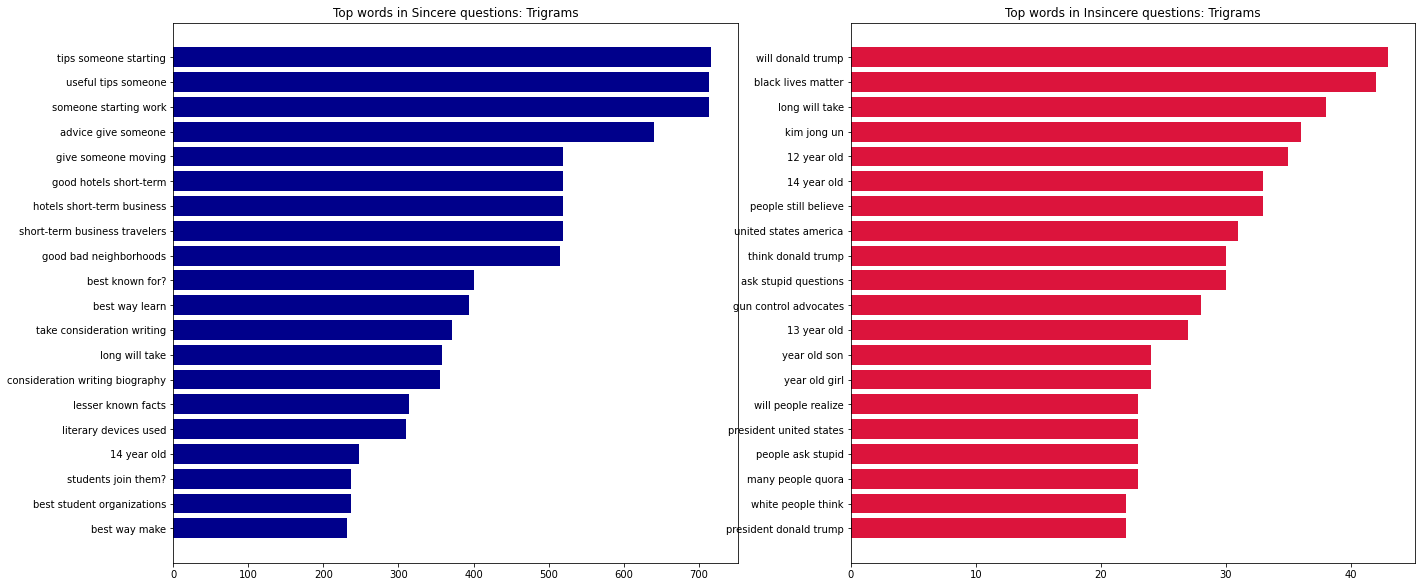

In [ ]:
# Trigrams Sincere words
plt.subplot(1, 2, 1)
top_word_freq(trigrams_sincere, 'Sincere questions: Trigrams', 'darkblue')

# Trigrams Insincere words
plt.subplot(1, 2, 2)
top_word_freq(trigrams_insincere, 'Insincere questions: Trigrams', 'crimson')
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()

In [ ]:
# Performing Feature Extraction Before text cleaning
# we would be constructing few features and will analyse those features using plots and graphs

# Number of words in a text
train_df['Number_of_words'] = train_df['question_text'].apply(lambda x: len(str(x).split()))
# test_df['Number_of_words'] = test_df['question_text'].apply(lambda x: len(str(x).split()))

train_df.head(5)

,qid,question_text,target,Number_of_words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15


In [ ]:
#Number of Capital letters in the text
train_df['Capital_Letters'] = train_df['question_text'].apply(lambda x: len([capital for capital in str(x) if capital.isupper()]))
# test_df['Capital_Letters'] = test_df['question_text'].apply(lambda x: len([capital for capital in str(x) if capital.isupper()]))

train_df.head(5)

,qid,question_text,target,Number_of_words,Capital_Letters
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3


In [ ]:
#Number of Special Characters in the text
train_df['num_of_special_char'] = train_df['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()
# test_df['num_of_special_char'] = test_df['question_text'].str.findall(r'[^a-zA-Z0-9 ]').str.len()

train_df.head(5)

,qid,question_text,target,Number_of_words,Capital_Letters,num_of_special_char
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1


In [ ]:
# train_df['question_text'][0]

In [ ]:
# Number of unique words
# set is used to get distinct elements from the text
train_df['num_of_unique_words'] = train_df['question_text'].apply(lambda x: len(set(str(x).split())))
# test_df['num_of_unique_words'] = test_df['question_text'].apply(lambda x: len(set(str(x).split())))

train_df.head(5)

,qid,question_text,target,Number_of_words,Capital_Letters,num_of_special_char,num_of_unique_words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15


In [ ]:
# Number of numerical characters in the text
train_df['num_numerics'] = train_df['question_text'].apply(lambda x: sum(c.isdigit() for c in x))
# test_df['num_numerics'] = test_df['question_text'].apply(lambda x: sum(c.isdigit() for c in x))

train_df.head(5)

,qid,question_text,target,Number_of_words,Capital_Letters,num_of_special_char,num_of_unique_words,num_numerics
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0


In [ ]:
# Number of characters
train_df['num_char'] = train_df['question_text'].apply(lambda x: len(str(x)))
# test_df['num_char'] = test_df['question_text'].apply(lambda x: len(str(x)))

# train_df.head(5)

In [ ]:
# Number of stopwords
train_df['num_stopwords'] = train_df['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))
# test_df['num_stopwords'] = test_df['question_text'].apply(lambda x: len([c for c in str(x).lower().split() if c in STOPWORDS]))

train_df.head(5)

,qid,question_text,target,Number_of_words,Capital_Letters,num_of_special_char,num_of_unique_words,num_numerics,num_char,num_stopwords
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7


In [ ]:

# Analysing the extracted features
print("Minimum length of a question:", min(train_df['Number_of_words']))
print("Maximum length of a question:", max(train_df['Number_of_words']))

Minimum length of a question: 1
Maximum length of a question: 134


In [ ]:
# Visualising the extracted features
def box_plot(x1,y1,dataset, title):
  sns.boxplot(x=x1, y=y1, data=dataset, palette='Blues') 
  plt.title(title)
  plt.grid(True)

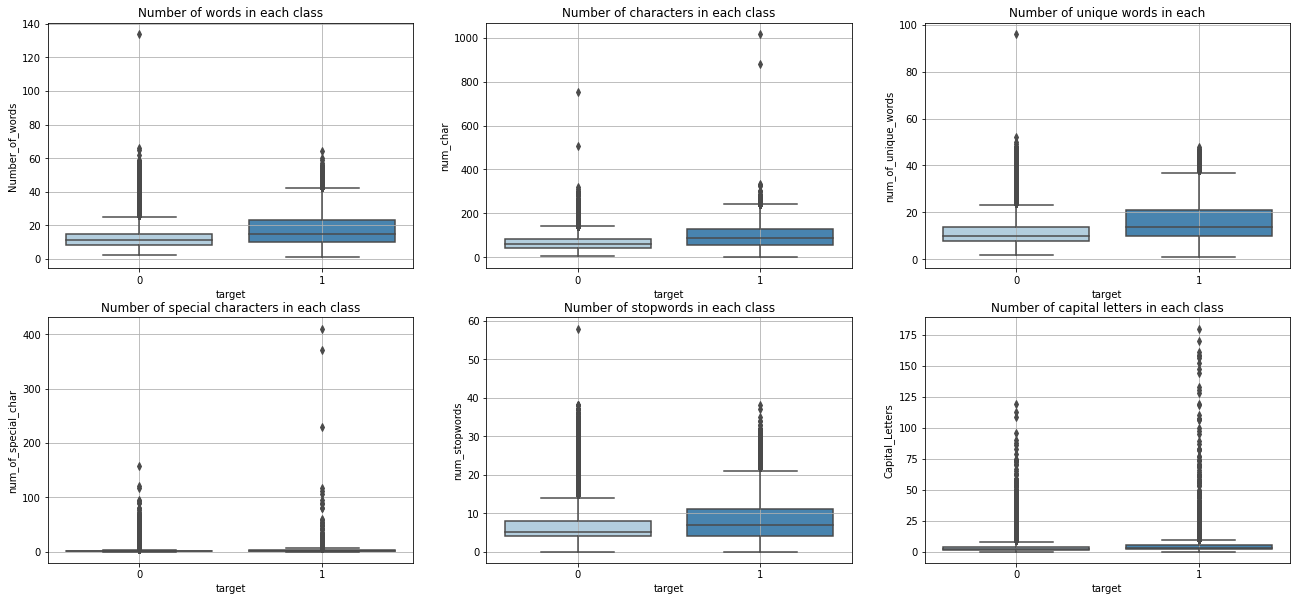

In [ ]:
# box plot for number of words in each target class
plt.subplot(2,3,1)
box_plot('target','Number_of_words',train_df,'Number of words in each class')

# box plot for number of characters in a text for each target class
plt.subplot(2,3,2)
box_plot('target','num_char',train_df,"Number of characters in each class")

# box plot for unique words in each target class
plt.subplot(2,3,3)
box_plot('target','num_of_unique_words',train_df,'Number of unique words in each')

# box plot for number for special characters in each class
plt.subplot(2,3,4)
box_plot('target','num_of_special_char',train_df,"Number of special characters in each class")

#box plot for number of stopwords in each class
plt.subplot(2,3,5)
box_plot('target','num_stopwords',train_df,"Number of stopwords in each class")

#box plot number for capital letters in each class
plt.subplot(2,3,6)
box_plot('target','Capital_Letters',train_df,"Number of capital letters in each class")
plt.subplots_adjust(right=3.0)
plt.subplots_adjust(top=2.0)
plt.show()


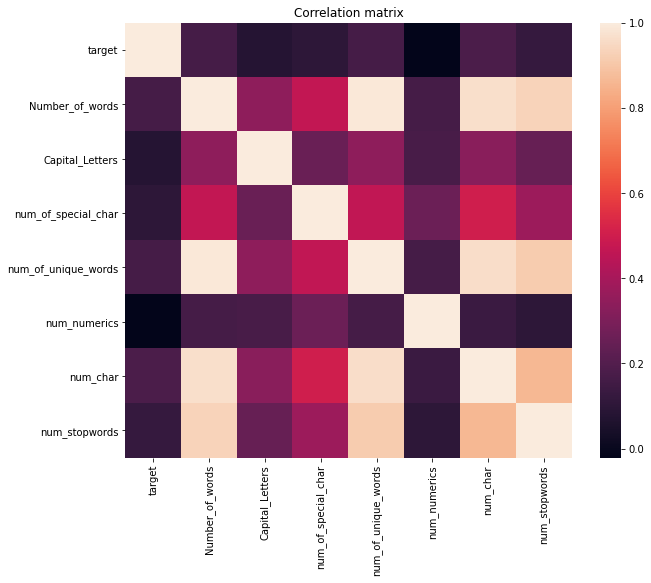

In [ ]:
# Correlation matrix
plt.figure(figsize=(10,8))
corr = train_df.corr()
sns.heatmap(corr)
plt.title("Correlation matrix")
plt.show()

**Observations**


*   Insincere questions consists of more words and characters.
*   Insincere questions also have more unique words compared to unique characters.





In [ ]:
# Text Preprocessing and Cleaning
# Removing Numbers
# Removing HTML Tags
# Cleaning contractions.
# Spell Correction.
# Removing punctuations.
# Removing Stopwords.
# Using WordNet Lemmatizer

In [ ]:
# Replacing numbers and html tags from the text
from bs4 import BeautifulSoup
def remove_html_tags(data):
  return BeautifulSoup(data, 'html.parser').get_text()

# creating a function to remove special characters or numbers from the text
def remove_special_char(data):
  pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
  return re.sub(pat, '', data)



In [ ]:
# Punctuation removal
def punct_removal(data):
  data = ''.join([item for item in data if item not in string.punctuation])
  return data
# the above method will remove this punctuation from the code !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
# Correcting the mispellings in the sentences
mispellings = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_words(data):
  words = data.split()
  for i in range(0,len(words)):
    if mispellings.get(words[i]) is not None:
      words[i] = mispellings.get(words[i])
    elif mispellings.get(words[i].lower()) is not None:
      words[i] = mispellings.get(words[i].lower())

  words = " ".join(words)
  return words

In [ ]:
# Stopwords Removal
def stopword_removal(data):
  data = [word for word in data.split() if word not in STOPWORDS]
  data = ' '.join(data)
  return data

In [ ]:
# Contractions are nothing but shortened versions of words or syllables
# there are functions for contraction removal 
# but we will be using our custom made dictionary which contains list of contraction 
contractions = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", 
                       "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", 
                       "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", 
                       "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", 
                       "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had",
                       "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", 
                       "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not",
                       "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", 
                       "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is",
                       "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", 
                       "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", 
                       "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", 
                       "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", 
                       "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", 
                       "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not",
                       "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", 
                       "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                       "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                       "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", 
                       "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                       "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                       "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                       "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", 
                       "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                       "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", 
                       "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
                       "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])
    return text

In [ ]:
#Converting the text into lower case
def text_lower(data):
  return data.lower()

In [ ]:
#Lemmatization : it is used to generate the root of the word
lemmatizer = WordNetLemmatizer()
def lemma(data):
  data = data.split()
  data = [lemmatizer.lemmatize(word) for word in data]
  data = ' '.join(data)
  return data

In [ ]:
def text_cleaning(data):
  data = remove_html_tags(data)
  data = remove_special_char(data)
  data = punct_removal(data)
  data = correct_words(data)
  data = stopword_removal(data)
  data = clean_contractions(data)
  data = text_lower(data)
  data = lemma(data)
  return data

In [ ]:
# preprocessing train and test data
%%time
train_df['clean_train_text'] = train_df['question_text'].apply(lambda data: text_cleaning(data))
test_df['clean_test_text'] = test_df['question_text'].apply(lambda data: text_cleaning(data))

CPU times: user 2min 56s, sys: 15 s, total: 3min 11s
Wall time: 3min 11s


In [ ]:
train_df.head()

,qid,question_text,target,Number_of_words,Capital_Letters,num_of_special_char,num_of_unique_words,num_numerics,num_char,num_stopwords,clean_train_text
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,13,2,1,13,4,72,7,how quebec nationalist see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,16,1,2,15,0,81,10,do adopted dog encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,10,2,2,8,0,67,3,why velocity affect time doe velocity affect s...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,9,4,1,9,0,57,3,how otto von guericke used magdeburg hemisphere
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,15,3,1,15,0,77,7,can i convert montra helicon d mountain bike c...


In [ ]:
test_df.head()

,qid,question_text,clean_test_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...,why many woman become rude arrogant little bit...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...,when i apply rv college engineering bm college...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...,what really nurse practitioner
3,000086e4b7e1c7146103,Who are entrepreneurs?,who entrepreneur
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?,is education really making good people nowadays


In [ ]:
test_df.shape

(375806, 3)

In [ ]:
# Splitting the training data set into Train and Test Set for evaluating the performance of the model.
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df,test_size = 0.2, random_state = 42 )

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

top_words = 6000 # number of unique words in each word vector
tokenizer = Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(list(train['clean_train_text'])+list(test['clean_train_text']))
tokenized_train = tokenizer.texts_to_sequences(train['clean_train_text'])

word_index = tokenizer.word_index
# tokenized_train_test = tokenizer.texts_to_sequences(test['clean_train_text']) # X_test

# tokenized_test = tokenizer.texts_to_sequences(test_df['clean_test_text'])


#padding converts the integer array of variable length into fixed length either by truncating the maxlength or padding
max_text_length = 130 # max number of words to be used in each question
X_train = pad_sequences(tokenized_train, maxlen=max_text_length) #tokenized_train = X_train
y_train = train['target'] # train['target'] = y_train


# test_text = pad_sequences(tokenized_test,maxlen = max_text_length)

In [ ]:
#the Glove Model use for this model implementation consisted 840 Billion tokens consisting 2.2 million vocabs each of 300 dimension

In [ ]:
# Zipping GloVe Embedding for the word embedding as a model
!wget 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
!unzip '/content/glove.840B.300d.zip'

--2020-12-11 01:31:15--  http://nlp.stanford.edu/data/glove.840B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.840B.300d.zip [following]
--2020-12-11 01:31:15--  https://nlp.stanford.edu/data/glove.840B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip [following]
--2020-12-11 01:31:16--  http://downloads.cs.stanford.edu/nlp/data/glove.840B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2176768927 (2.0G) [application/zip

In [ ]:
# # preparing the embedding layer by applying Glove Embedding
embeddings_index_glove= {}

f = open('/content/glove.840B.300d.txt',encoding='utf-8')
for line in f:
  values = line.rsplit(' ')
  word = values[0]
  coeff = np.asarray(values[1:],dtype='float32')
  embeddings_index_glove[word] = coeff
f.close()

print('Found %s word vectors.' %len(embeddings_index_glove))


Found 2196016 word vectors.


In [ ]:
# we can use embedding index and word index to create a embedding matrix
embedding_dim_glove = 300
embedding_matrix_glove = np.zeros((len(word_index) + 1, embedding_dim_glove))
for word , i in word_index.items():
  embedding_vector_glove = embeddings_index_glove.get(word)
  if embedding_vector_glove is not None:     # words not found in embedding index will be all-zeros.
    embedding_matrix_glove[i] = embedding_vector_glove
    

In [ ]:
  # We load this embedding matrix into an Embedding layer. 
  # we set trainable=False to prevent the weights from being updated during training. 
  # Previously we used the default Embedding layer, withtrainable=True ,
  # which learned the Embeddings through the training process.

  glove_emb_layer = Embedding(len(word_index)+1,
                              embedding_dim_glove,
                              weights= [embedding_matrix_glove],
                              input_length = max_text_length,
                              trainable = False)

In [ ]:
# # Tokenising the main test dataset 
# tokenizer.fit_on_texts(list(train_df['clean_train_text'])+ list(test_df['clean_test_text']))
# tokenized_test = tokenizer.texts_to_sequences(test_df['clean_test_text'])
# test_text = pad_sequences(tokenized_test,maxlen = max_text_length)

In [ ]:
# Importing Deep Learning Libraries

from keras.layers import Embedding
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional, SpatialDropout1D
# Generally, we use softmax activation instead of sigmoid with the cross-entropy loss 
# because softmax activation distributes the probability throughout each output node.
# But, since it is a binary classification, using sigmoid is same as softmax. 




In [ ]:
# Model 1: Baseline LSTM Model For Text Classification
quora_model = Sequential()
quora_model.add(glove_emb_layer)
quora_model.add(SpatialDropout1D(0.2)) 
quora_model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2)) #dropout is used to prevent the model from overfitting.
quora_model.add(Dense(1,activation='sigmoid')) # sigmoid passes the output in 0's and 1's
quora_model.compile(loss='binary_crossentropy',optimizer ='adam',metrics =['accuracy'])


print(quora_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 130, 300)          69792300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 130, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 69,885,805
Trainable params: 93,505
Non-trainable params: 69,792,300
_________________________________________________________________
None


In [ ]:
model = quora_model.fit(X_train,y_train,epochs=5, batch_size=1024, validation_split=0.2)

Epoch 1/5
817/817 [==============================] - 399s 488ms/step - loss: 0.1300 - accuracy: 0.9499 - val_loss: 0.1259 - val_accuracy: 0.9514
Epoch 2/5
817/817 [==============================] - 400s 489ms/step - loss: 0.1236 - accuracy: 0.9523 - val_loss: 0.1227 - val_accuracy: 0.9527
Epoch 3/5
817/817 [==============================] - 398s 487ms/step - loss: 0.1198 - accuracy: 0.9538 - val_loss: 0.1184 - val_accuracy: 0.9540
Epoch 4/5
817/817 [==============================] - 397s 486ms/step - loss: 0.1174 - accuracy: 0.9546 - val_loss: 0.1172 - val_accuracy: 0.9543
Epoch 5/5
817/817 [==============================] - 397s 486ms/step - loss: 0.1158 - accuracy: 0.9552 - val_loss: 0.1172 - val_accuracy: 0.9546


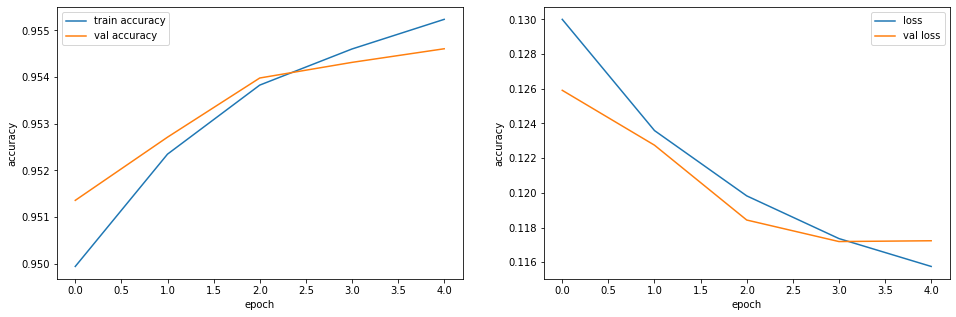

In [ ]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.plot(model.history['accuracy'], label='train accuracy')
plt.plot(model.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();


plt.subplot(1,2,2)
plt.plot(model.history['loss'], label='loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

plt.show()

In [ ]:
# predicting train_test result
%%time
tokenized_train_test = tokenizer.texts_to_sequences(test['clean_train_text']) # X_test
X_test = pad_sequences(tokenized_train_test, maxlen=max_text_length)
y_test = test['target']
prediction_train_test = quora_model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CPU times: user 4min 10s, sys: 1.53 s, total: 4min 12s
Wall time: 4min 9s


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print("Accuracy of the model : ", accuracy_score(prediction_train_test, y_test))
print('F1-score: ', f1_score(prediction_train_test, y_test))
print('Confusion matrix:')
confusion_matrix(y_test,prediction_train_test)

Accuracy of the model :  0.9562943822375347
F1-score:  0.5996423186169654
Confusion matrix:


array([[241258,   4111],
       [  7306,   8550]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,prediction_train_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    245369
           1       0.68      0.54      0.60     15856

    accuracy                           0.96    261225
   macro avg       0.82      0.76      0.79    261225
weighted avg       0.95      0.96      0.95    261225



In [ ]:
%%time
tokenized_test = tokenizer.texts_to_sequences(test_df['clean_test_text'])
test_text = pad_sequences(tokenized_test,maxlen = max_text_length)
prediction_test_set = quora_model.predict_classes(test_text)

CPU times: user 5min 57s, sys: 2.75 s, total: 6min
Wall time: 5min 57s


In [ ]:
prediction_test_set

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [ ]:
# Generating a csv file from the prediction data which will be then compared with the original submission file received with dataset.
prediction_test = prediction_test_set.reshape((-1,1))
submission = test_df[['qid']].copy()
submission['prediction'] = prediction_test
submission.to_csv('submission_baseline.csv',index = False)